# COMP579 Assignment 3

**Value-based methods with linear function approximation [40 points]**

In [1]:
import os
import random
import gymnasium as gym
import numpy as np
import pandas as pd
from functools import partial

from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from itertools import product
from tqdm.auto import tqdm
import seaborn as sns

import multiprocessing as mp

In [2]:
# These variables affect how long the notebook takes to run
num_runs = 5       # 50
n_episodes = 200   # 1000

## Environments

## Mountain Car

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. This version is the one with discrete actions.

This MDP first appeared in Andrew Moore’s PhD Thesis (1990)

|  |  |
| ---- | ---- |
| Action space | `Discrete(3)` |
| Observation Space | `Box([-1.2 -0.07], [0.6 0.07], (2,), float32)` |
| Import | `gymnasium.make("MountainCar-v0")` |

### Observation Space

The observation is a ndarray with shape `(2,)` where the elements correspond to the following:

| Num | Observation                               | Min   | Max  | Unit           |
|-----|-------------------------------------------|-------|------|----------------|
| 0   | position of the car along the x-axis      | -1.2  | 0.6  | position (m)   |
| 1   | velocity of the car                       | -0.07 | 0.07 | velocity (v)   |

### Action Space

There are 3 discrete deterministic actions:

- 0: Accelerate to the left
- 1: Don’t accelerate
- 2: Accelerate to the right

### Transition Dynamics:

Given an action, the mountain car follows the following transition dynamics:

`velocity_{t+1} = velocity_t + (action - 1) * force - cos(3 * position_t) * gravity`

`position_{t+1} = position_t + velocity_{t+1}`

where `force = 0.001` and `gravity = 0.0025`. The collisions at either end are inelastic with the velocity set to 0 upon collision with the wall. The position is clipped to the range `[-1.2, 0.6]` and velocity is clipped to the range `[-0.07, 0.07]`.

### Reward:

The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.

### Starting State

The position of the car is assigned a uniform random value in `[-0.6 , -0.4]`. The starting velocity of the car is always assigned to 0.

### Episode End

The episode ends if either of the following happens:

- Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
- Truncation: The length of the episode is 200.

In [3]:
mountaincart_env = gym.make("MountainCar-v0")

## Cart Pole

This environment is part of the Classic Control environments which contains general information about the environment.

|  |  |
| ---- | ---- |
| Action space | `Discrete(2)` |
| Observation Space | `Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)` |
| Import | `gymnasium.make("CartPole-v1")` |

### Description

This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

### Action Space

The action is an ndarray with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.

- `0`: Push cart to the left
- `1`: Push cart to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

### Observation Space

The observation is an ndarray with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation         | Min     | Max     |
|-----|---------------------|---------|---------|
| 0   | Cart Position       | -4.8    | 4.8     |
| 1   | Cart Velocity       | -Inf    | Inf     |
| 2   | Pole Angle          | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf  | Inf     |

Note: While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

- The cart x-position (index 0) can take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.
- The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°).

## Rewards

Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 500 for v1 and 200 for v0.

## Starting State

All observations are assigned a uniformly random value in (-0.05, 0.05).

## Episode End

The episode ends if any one of the following occurs:

- Termination: Pole Angle is greater than ±12°.
- Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display).
- Truncation: Episode length is greater than 500 (200 for v0).

In [4]:
cartpole_env = gym.make("CartPole-v1")

### Tile-coding
- Discretise the state space for both the environments using an appropriate tile-coding (see section 9.5.4 of the RL book http://incompleteideas.net/book/RLbook2020.pdf for how to do tilecoding).
- It is generally recommended to use at most 10 tiles (bins) per state variable, but you are free to choose more tiles if it results in better performance.
- It is easier to imagine tiling each dimension of the state-space independently, in that case, one tiling of $s_2$, for example, is just one way to make bins out of $s_2$.
- So suppose the state-space is 2D so we have the state is $s = (s_1 , s_2)$.
- Suppose we have 2 tilings of 5 tiles (bins) each per dimension of $s$, idea is to convert the state representation from $s$ to the $2*2*5=20$ dim vector:
$$x = (x_{1,1,1} , x_{1,1,2} , \ldots , x_{1,1,5} , x_{1,2,1}, \ldots , x_{1,2,5} , x_{2,1,1} , x_{2,1,2} , \ldots , x_{2,1,5} , x_{2,2,1} , \ldots , x_{2,2,5}),$$
which contains only 1s and 0s where $x_{i,j,k} = 1$ iff $s_i$ is in tile $k$ of the $j$-th tiling (of the $i$-th state dimension), and 0 otherwise.

In [5]:
class TileCoder:
    def __init__(self, limits, bin_sizes, num_frames):
        """
        Initialize a generalized TileCoder.

        :param limits: A list of tuples where each tuple is (min_value, max_value) for a dimension.
        :param bin_sizes: A list of integers indicating the number of bins for each dimension.
        :param num_frames: Number of frames to be used for tiling.
        """
        assert 1 <= len(limits) <= 4, "This TileCoder supports 1 to 4 dimensions."
        assert len(limits) == len(bin_sizes), "Each dimension must have a corresponding bin size."

        self.limits = limits
        self.bin_sizes = bin_sizes
        self.num_frames = num_frames
        self.dimensionality = len(limits)

        # Calculate the unit sizes and bins for each dimension
        self.unit_sizes = [(limit[1] - limit[0]) / bin_size for limit, bin_size in zip(limits, bin_sizes)]
        self.bins = [[np.linspace(limit[0], limit[1], bin_size + 1) + self.unit_sizes[dim] * (i + 1) / num_frames
                      for i in range(-num_frames, num_frames - 1)] for dim, (limit, bin_size) in enumerate(zip(limits, bin_sizes))]

    
    def get_active_tiles(self, point, flatten=True):
        """
        Get active tiles for the given point.

        :param points: A list or array of points, one for each dimension.
        :param flatten: If True, returns a flattened array of active tiles.
        :return: Array of active tiles.
        """
        frames = np.zeros([self.num_frames * 2 - 1] + [size for size in self.bin_sizes])
        frame_indices = [[np.searchsorted(frame, point[dim]) for frame in self.bins[dim]] for dim in range(self.dimensionality)]
        
        skip = False
        for i, idxs in enumerate(zip(*frame_indices)):
            for j, idx in enumerate(idxs):
                if idx >= self.bin_sizes[j]:
                    skip = True
            if skip:
                skip = False
                continue
            idxs = tuple([i]) + idxs
            frames[idxs] = 1

        return frames.flatten()

    def get_number_of_frames(self):
        """
        Returns the number of frames to be generated by the tilecoder
        """
        active_tiles = self.get_active_tiles(tuple([0] * self.dimensionality))
        return len(active_tiles)

    def plot_frames(self):
        if self.dimensionality != 2:
            raise NotImplementedError("Plotting is only implemented for 2-dimensional tile coders.")

        plt.figure(figsize=(8, 6))
        colors = plt.cm.viridis(np.linspace(0, 1, self.num_frames))

        for i, (x_bins, y_bins) in enumerate(zip(self.bins[0], self.bins[1])):
            X, Y = np.meshgrid(x_bins, y_bins)
            plt.plot(X, Y, 'o-', color=colors[i % self.num_frames], markersize=2, linewidth=1, alpha=0.7)
            plt.plot(X.T, Y.T, 'o-', color=colors[i % self.num_frames], markersize=2, linewidth=1, alpha=0.7)

        # Drawing the boundary
        x_min, x_max = self.limits[0]
        y_min, y_max = self.limits[1]
        plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'r-', linewidth=2)

        plt.title('Tile-coding plot for 2D')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.grid(True)
        plt.show()

# Example usage for a 2D tile coder:
mountaincart_tiling = TileCoder(
    limits=[(-1.2, 0.6), (-0.07, 0.07)],
    bin_sizes=[5, 5],
    num_frames=4
)

cartpole_tiling = TileCoder(
    limits=[(-4.8, 4.8), (-5, 5), (-0.73, 0.73), (-5, 5)],
    bin_sizes=[5, 5, 5, 5],
    num_frames=4
)

### Plot the Tile-coding

We plot the tile-coding we generated to check that we got it right

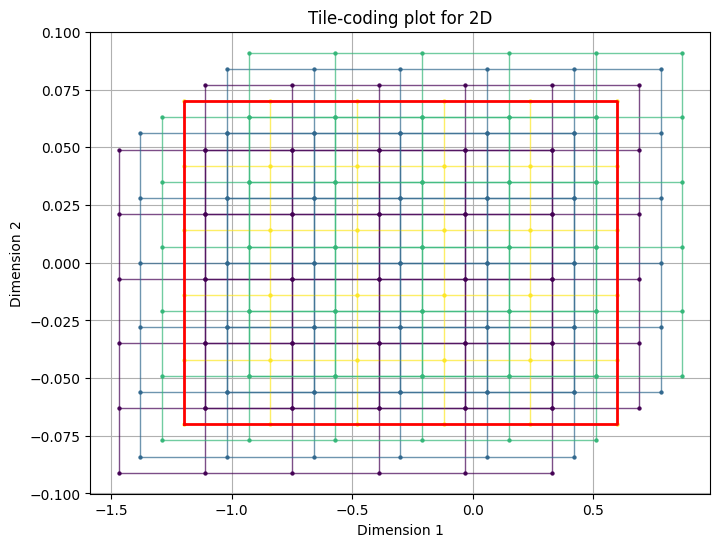

In [6]:
mountaincart_tiling.plot_frames()

### Q Learner and Expected SARSA
Implement Q-learning and Expected SARSA for both `MountainCar-v0` and `CartPole-v1` environments from the Gym suite using the following guidelines:

- Use a linear function approximation for $Q$, that is, if $x$ is a vector representing the state and $\theta$ a is the action vector, use $$Q(x, a) = \sum^{d}_{i=1} θ_{a,i} x_i$$ where $\theta$ are the parameters of the $Q$-function you
need to learn, $d$ is the dimension of $x$ and $a \in \{1, \cdots , m\}$ is a discrete action.

In [7]:
class QLearner:
    """
    A class representing the Q-learning algorithm.

    Attributes:
        env (gym.Env): The environment to interact with.
        alpha (float): The learning rate.
        gamma (float): The discount factor for future rewards.
        theta (numpy.ndarray): The weight matrix for storing state-action values.

    Methods:
        select_action(s, greedy=False): Selects an action based on the current policy.
        update(s, a, r, s_prime, done): Updates the weight matrix based on the observed transition.
    """

    def __init__(self, env, tiling, alpha, gamma, epsilon, run=0):
        """
        Initializes the Q-learning agent.

        Parameters:
            env (gym.Env): The environment to interact with.
            tiling (TileCoder): The tile-coding implementation for this environment.
            alpha (float): The learning rate.
            gamma (float): The discount factor for future rewards.
            epsilon (float): The exploration rate for epsilon-greedy action selection.
            input_size (int): The size of the input space.
            action_size (int): The size of the action space.
            run (int): Optionally add the run ID for this model
        """
        self.name = 'QLearner'
        self.env = env
        self.tiling = tiling
        self.input_size = tiling.get_number_of_frames()
        self.action_size = env.action_space.n
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.run = run
        
        # Initialize Q-values (weights) uniformly between -0.001 and 0.001
        self.theta = np.random.uniform(-0.001, 0.001, (self.input_size, self.action_size))

    def __repr__(self):
        return f"{self.name}(run={self.run}, alpha={self.alpha}, gamma={self.gamma}, epsilon={self.epsilon}, input_size={self.input_size}, action_size={self.action_size})"

    def select_action(self, s, greedy=False):
        """
        Selects an action based on the current policy using epsilon-greedy method.

        Parameters:
            s (int): The current state.
            greedy (bool): If True, selects the action with the highest Q-value.

        Returns:
            int: The selected action.
        """
        if greedy or np.random.rand() > self.epsilon:
            # Do the greedy thing
            Q_values = np.dot(s, self.theta)
            return np.argmax(Q_values)
        else:
            # Take a random action
            return np.random.choice(list(range(self.action_size)))

    def update(self, s, a, r, s_prime, done):
        """
        Updates the weight matrix based on the observed transition using the Q-learning update rule and applies L2 regularization.

        Parameters:
            s (int): The current state.
            a (int): The action taken.
            r (float): The reward received.
            s_prime (int): The next state.
            done (bool): Whether the episode has ended.
        """
        current_Q = np.dot(s, self.theta[:, a])
        Q_prime = 0 if done else np.max(np.dot(s_prime, self.theta))
        td_error = r + self.gamma * Q_prime - current_Q
        self.theta[:, a] += self.alpha * td_error * s

    def train(self, n_episodes=1000):

        train_history = []
        
        for episode in tqdm(range(n_episodes)):
            s, info = self.env.reset()
            s = self.tiling.get_active_tiles(s)
            done = False
            total_reward = 0
            segment = 0
    
            while not done and segment < self.env._max_episode_steps:
                a = self.select_action(s)
                s_prime, r, done, trunc, info = self.env.step(a)
                s_prime = self.tiling.get_active_tiles(s_prime)
                self.update(s, a, r, s_prime, done)
                s = s_prime
                total_reward += r
                segment += 1
    
            train_history.append({
                'env': self.env.unwrapped.spec.id,
                'run': self.run,
                'model_name': self.name,
                'episode': episode,
                'num_segments': segment,
                'total_reward': total_reward,
                'alpha': self.alpha,
                'gamma': self.gamma,
                'epsilon': self.epsilon
            })
    
        return pd.DataFrame(train_history)


class ExpectedSarsa:
    """
    A class representing the Expected-Sarsa algorithm.

    Attributes:
        env (gym.Env): The environment to interact with.
        alpha (float): The learning rate.
        gamma (float): The discount factor for future rewards.
        theta (numpy.ndarray): The weight matrix for storing state-action values.

    Methods:
        select_action(s, greedy=False): Selects an action based on the current policy.
        update(s, a, r, s_prime, done): Updates the weight matrix based on the observed transition.
    """

    def __init__(self, env, tiling, alpha, gamma, epsilon, run=0):
        """
        Initializes the Expected-Sarsa agent.

        Parameters:
            env (gym.Env): The environment to interact with.
            tiling (TileCoder): The tile-coding implementation for this environment.
            alpha (float): The learning rate.
            gamma (float): The discount factor for future rewards.
            epsilon (float): The exploration rate for epsilon-greedy action selection.
            input_size (int): The size of the input space.
            action_size (int): The size of the action space.
            run (int): Optionally add the run ID for this model
        """
        self.name = 'ExpectedSarsa'
        self.env = env
        self.tiling = tiling
        self.input_size = tiling.get_number_of_frames()
        self.action_size = env.action_space.n
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.run = run
        
        # Initialize Q-values (weights) uniformly between -0.001 and 0.001
        self.theta = np.random.uniform(-0.001, 0.001, (self.input_size, self.action_size))

    def __repr__(self):
        return f"{self.name}(run={self.run}, alpha={self.alpha}, gamma={self.gamma}, epsilon={self.epsilon}, input_size={self.input_size}, action_size={self.action_size})"

    def select_action(self, s, greedy=False):
        """
        Selects an action based on the current policy using epsilon-greedy method.

        Parameters:
            s (int): The current state.
            greedy (bool): If True, selects the action with the highest Q-value.

        Returns:
            int: The selected action.
        """
        if greedy or np.random.rand() > self.epsilon:
            # Do the greedy thing
            Q_values = np.dot(s, self.theta)
            return np.argmax(Q_values)
        else:
            # Take a random action
            return np.random.choice(list(range(self.action_size)))


    def update(self, s, a, r, s_prime, done):
        """
        Updates the weight matrix based on the observed transition using the Expected SARSA update rule.

        Parameters:
            s (int): The current state.
            a (int): The action taken.
            r (float): The reward received.
            s_prime (int): The next state.
            done (bool): Whether the episode has ended.
        """
        current_Q = np.dot(s, self.theta[:, a])
        
        # Compute the expected Q value for the next state
        if done:
            expected_Q_prime = 0
        else:
            Q_values_next = np.dot(s_prime, self.theta)
            greedy_actions = np.argwhere(Q_values_next == np.amax(Q_values_next)).flatten()
            non_greedy_prob = self.epsilon / self.action_size
            greedy_prob = ((1 - self.epsilon) / len(greedy_actions)) + non_greedy_prob
            expected_Q_prime = np.sum([Q_values_next[next_a] * (greedy_prob if next_a in greedy_actions else non_greedy_prob) for next_a in range(self.action_size)])

        # Compute the temporal difference error
        td_error = r + self.gamma * expected_Q_prime - current_Q

        # Update the weights
        self.theta[:, a] += self.alpha * td_error * s

    def update(self, s, a, r, s_prime, done):
        """
        Updates the weight matrix based on the observed transition using the Q-learning update rule and applies L2 regularization.

        Parameters:
            s (int): The current state.
            a (int): The action taken.
            r (float): The reward received.
            s_prime (int): The next state.
            done (bool): Whether the episode has ended.
        """
        current_Q = np.dot(s, self.theta[:, a])
        Q_prime = 0 if done else np.max(np.dot(s_prime, self.theta))
        td_error = r + self.gamma * Q_prime - current_Q
        self.theta[:, a] += self.alpha * td_error * s

    def train(self, n_episodes=1000):

        train_history = []
        
        for episode in tqdm(range(n_episodes)):
            s, info = self.env.reset()
            s = self.tiling.get_active_tiles(s)
            done = False
            total_reward = 0
            segment = 0
    
            while not done and segment < self.env._max_episode_steps:
                a = self.select_action(s)
                s_prime, r, done, trunc, info = self.env.step(a)
                s_prime = self.tiling.get_active_tiles(s_prime)
                self.update(s, a, r, s_prime, done)
                s = s_prime
                total_reward += r
                segment += 1
    
            train_history.append({
                'env': self.env.unwrapped.spec.id,
                'run': self.run,
                'model_name': self.name,
                'episode': episode,
                'num_segments': segment,
                'total_reward': total_reward,
                'alpha': self.alpha,
                'gamma': self.gamma,
                'epsilon': self.epsilon
            })
    
        return pd.DataFrame(train_history)

### Hyperparameters
- Initalise the parameters for the value function uniformly between −0.001 and 
0.001.
- Use an $\varepsilon$-greedy policy with three choices of $\varepsilon$ and step-size parameters 1/4, 1/8, 1/16 and
run 50 learning trials with different initialisations for $Q$, each having 1000 episodes, for each
configuration. (That means 3 configs * 50 runs * 1000 episodes).


In [8]:
import numpy as np
import random
from itertools import product

# Assuming QLearner and other necessary variables are defined elsewhere
epsilons = [0.005, 0.01, 0.02]
alphas = [1/4, 1/8, 1/16]
gammas = [0.995]

# Generate all possible combinations
all_combinations = list(product(gammas, alphas, epsilons))

# Create models based on the randomly selected combinations
mountaincart_agents = [
    Agent(
        run=run,
        env=mountaincart_env,
        tiling=mountaincart_tiling,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon
    )
      for Agent in [QLearner, ExpectedSarsa] \
      for run in range(num_runs) \
      for gamma, alpha, epsilon in all_combinations
]

cartpole_agents = [
    Agent(
        run=run,
        env=cartpole_env,
        tiling=cartpole_tiling,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon
    )
      for Agent in [QLearner, ExpectedSarsa] \
      for run in range(num_runs) \
      for gamma, alpha, epsilon in all_combinations
]

agents = mountaincart_agents + cartpole_agents
random.shuffle(agents)

def train_agent(agent, n_episodes):
    history = agent.train(n_episodes = n_episodes)
    return agent, history

In [9]:
agent, history = train_agent(random.choice(agents), n_episodes=n_episodes)

  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
def train_parallel_agents(agents, n_episodes):
    pool = Pool(processes=cpu_count())
    results = list(tqdm(pool.imap(partial(train_agent, n_episodes=n_episodes), agents), total=len(agents)))
    pool.close()
    pool.join()
    return results

In [11]:
def compile_results(results):
    results_df = pd.concat([result[1] for result in results if result is not None]).reset_index(drop=True)
    results_df['experiment_name'] = results_df.apply(lambda x: f'model={x.model_name},env={x.env},run={x.run}, alpha={x.alpha:.4f}, gamma={x.gamma:.3f}, epsilon={x.epsilon:.4f}', axis=1)
    results_df = results_df.sort_values('experiment_name')
    results_df['return'] = results_df.groupby('experiment_name')['total_reward'].apply(np.cumsum).reset_index(drop=True)
    results_df['cumulative_reward'] = results_df.groupby('experiment_name')['total_reward'].apply(np.cumsum).reset_index(drop=True)
    return results_df

results_csv_path = 'data/results_df.csv'
if not os.path.exists(results_csv_path):
    results = train_parallel_agents(agents, n_episodes=n_episodes)
    results_df = compile_results(results)
    results_df.to_csv(results_csv_path, index=False)
else:
    results_df = pd.read_csv(results_csv_path)

In [12]:
(results_df.groupby('experiment_name')
     .tail(100)
     .groupby('experiment_name')
     ['total_reward']
     .mean()
     .sort_values(ascending=False)
     .reset_index()
)

,experiment_name,total_reward
0,"model=QLearner,env=CartPole-v1,run=1, alpha=0....",180.49
1,"model=ExpectedSarsa,env=CartPole-v1,run=2, alp...",166.62
2,"model=QLearner,env=CartPole-v1,run=0, alpha=0....",159.32
3,"model=QLearner,env=CartPole-v1,run=4, alpha=0....",159.22
4,"model=QLearner,env=CartPole-v1,run=2, alpha=0....",158.61
...,...,...
175,"model=ExpectedSarsa,env=MountainCar-v0,run=3, ...",-200.00
176,"model=ExpectedSarsa,env=MountainCar-v0,run=4, ...",-200.00
177,"model=QLearner,env=MountainCar-v0,run=4, alpha...",-200.00
178,"model=QLearner,env=MountainCar-v0,run=4, alpha...",-200.00


### Plots
- Plot the average performance of the policy on the Y-axis and the number of episodes on the
X-axis. The plots should also include the interquantile range of the 50 independent runs. Note
that you are expected to plot 9 results corresponding to each $\varepsilon$ and step-size parameters for
both the environments, and document your findings in a separate pdf along with the results.
Explain why one algorithm performs better than the other or why a particular configuration
results in better performance.

In [13]:
import plotnine
from plotnine import ggplot, aes, geom_line, geom_ribbon, facet_wrap, ylab, xlab, theme_matplotlib, theme_set, ggtitle

plotnine.options.figure_size = (8, 4)

In [14]:
plot_df = (results_df
     .groupby(['env', 'model_name', 'episode', 'alpha', 'gamma', 'epsilon'])
     ['total_reward']
     .agg(['mean', lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.75)])
     .reset_index()
     .rename(columns={"<lambda_0>": "q25", "<lambda_1>": "q75"})
)
plot_df['Parameters'] = plot_df.apply(lambda x: f'alpha={x.alpha}, epsilon={x.epsilon}', axis=1)
plot_df.head()

,env,model_name,episode,alpha,gamma,epsilon,mean,q25,q75,Parameters
0,CartPole-v1,ExpectedSarsa,0,0.0625,0.995,0.005,8.8,9.0,9.0,"alpha=0.0625, epsilon=0.005"
1,CartPole-v1,ExpectedSarsa,0,0.0625,0.995,0.010,8.4,8.0,9.0,"alpha=0.0625, epsilon=0.01"
2,CartPole-v1,ExpectedSarsa,0,0.0625,0.995,0.020,9.6,9.0,10.0,"alpha=0.0625, epsilon=0.02"
3,CartPole-v1,ExpectedSarsa,0,0.1250,0.995,0.005,9.8,9.0,10.0,"alpha=0.125, epsilon=0.005"
4,CartPole-v1,ExpectedSarsa,0,0.1250,0.995,0.010,8.8,8.0,9.0,"alpha=0.125, epsilon=0.01"


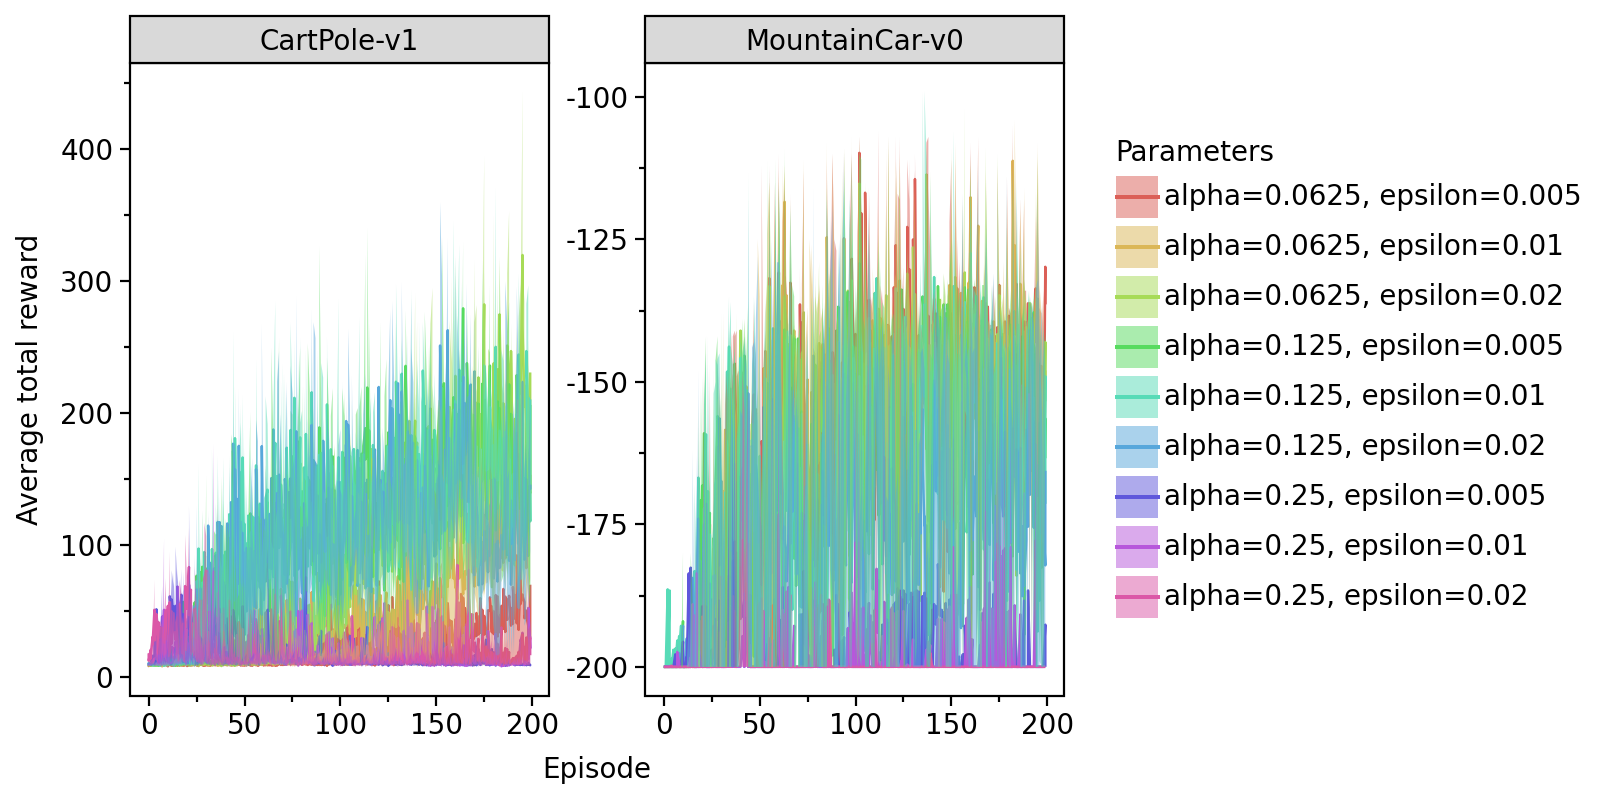

In [15]:
(ggplot(plot_df) +
     geom_line(aes(x="episode", y="mean", color="Parameters")) +
     facet_wrap('env', scales='free_y') +
     geom_ribbon(aes(x="episode", ymin = 'q25', ymax = 'q75', fill="Parameters"), alpha = 0.5) +
     ylab('Average total reward') +
     xlab('Episode') +
     theme_matplotlib()
)

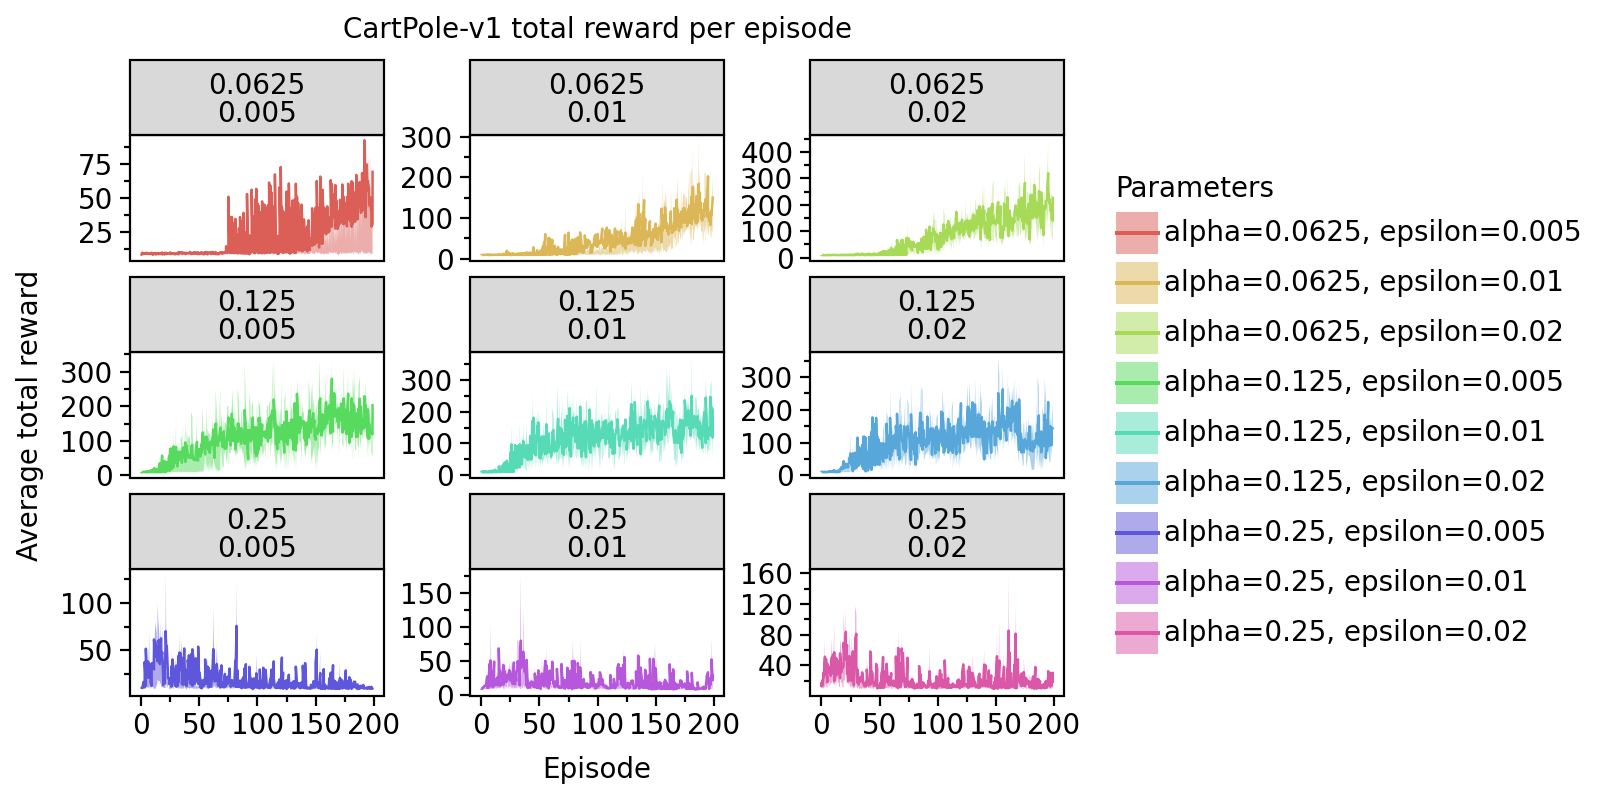

In [16]:
(ggplot(plot_df[plot_df.env == "CartPole-v1"]) +
     geom_line(aes(x="episode", y="mean", color="Parameters")) +
     facet_wrap('~alpha + epsilon', scales='free_y') +
     geom_ribbon(aes(x="episode", ymin = 'q25', ymax = 'q75', fill="Parameters"), alpha = 0.5) +
     ylab('Average total reward') +
     xlab('Episode') +
     theme_matplotlib() +
     ggtitle("CartPole-v1 total reward per episode")
)

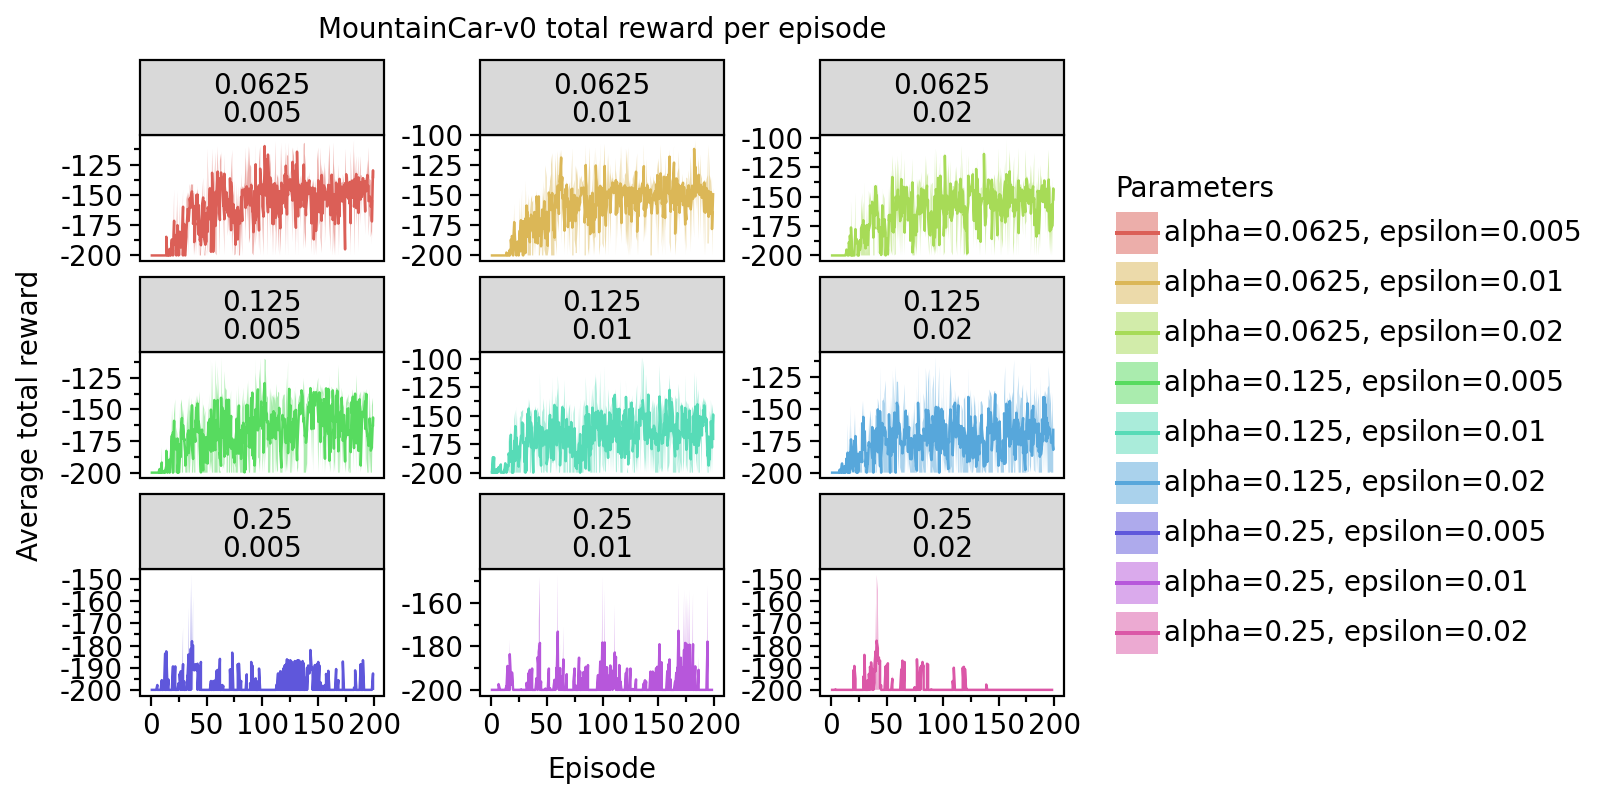

In [17]:
(ggplot(plot_df[plot_df.env == "MountainCar-v0"]) +
     geom_line(aes(x="episode", y="mean", color="Parameters")) +
     facet_wrap('~alpha + epsilon', scales='free_y') +
     geom_ribbon(aes(x="episode", ymin = 'q25', ymax = 'q75', fill="Parameters"), alpha = 0.5) +
     ylab('Average total reward') +
     xlab('Episode') +
     theme_matplotlib() +
     ggtitle("MountainCar-v0 total reward per episode")
)

### Rules
- Implement all the methods without using any automatic differentiation package. It is highly recommended that you undertake the development of software independently. Furthermore, it is essential to appropriately cite any resources or materials sourced from the
internet in your work.

**Value-based methods with linear function approximation [40 points]**

Implement REINFORCE and Actor-Critic method for both the MountainCar-v0 and CartPole-v1
environments.

$$ \pi(a_i|s) = \frac{\exp(z(s, a_i) / T)}{\sum_{a\in\mathcal{A}}\exp(z(s,a)/T)} $$

- Implement a Boltzmann Policy as the equation above and use a linear approximation for $z$. That is $z(x, a) = \sum_{i=1}^d \theta_i a x_i$, where $\theta$ are the parameters of $z$ you need to learn, $d$ is the dimension of $x$ (the state space representation), and $a \in \{1, \ldots, m\}$ is a discrete action. Like in part 1, $x$ is a tile coding of the state space $s$.
- Similar to value-based methods, use appropriate initialization of the policy parameters.

In [295]:
class REINFORCEAgent:
    def __init__(self, env, tiling, alpha, gamma, temp, temp_decay_rate=1.0, run=0):
        self.name='REINFORCE'
        self.run = run
        self.env = env
        self.env_name = env.unwrapped.spec.id
        self.tiling = tiling
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.temp = temp
        self.temp_decay_rate = temp_decay_rate  # Decay rate for the temperature
        self.num_actions = env.action_space.n
        self.observation_dim = tiling.get_number_of_frames()
        self.theta = np.random.uniform(-0.001, 0.001, (self.observation_dim, self.num_actions))

    def __repr__(self):
        return f"{self.name}(run={self.run}, env={self.env_name} alpha={self.alpha}, gamma={self.gamma}, temp={self.temp}, temp_decay_rate={self.temp_decay_rate})"
    
    def policy(self, state):
        """Compute the policy \pi(a|s, \theta) using softmax"""
        preferences = np.dot(state, self.theta) / self.temp
        max_preference = np.max(preferences)
        exp_preferences = np.exp(preferences - max_preference)
        return exp_preferences / np.sum(exp_preferences)

    def grad_policy(self, state, action):
        """Compute the gradient of the log policy with respect to theta for a given state and action"""
        softmax_probs = self.policy(state)
        grad = np.outer(state, softmax_probs)  # The term for all actions
        grad[:, action] -= state  # Subtracting for the taken action
        return grad

    def update_temperature(self):
        """Update the temperature using exponential decay"""
        self.temp = self.temp * self.temp_decay_rate

    def select_action(self, state):
        """Select action according to the policy"""
        probabilities = self.policy(state)
        return np.random.choice(self.num_actions, p=probabilities)

    def update(self, trajectory):
        """
        Update the policy based on a single episode trajectory.
        
        :param trajectory: Collected trajectory consisting of state, action, and reward tuples.
        :param min_grad_norm: Minimum norm for the gradient below which a warning is raised.
        """

        for t, (state, action, reward) in enumerate(trajectory):
            # Calculate the return from this step onwards.
            G_t = sum(self.gamma ** (k - t) * r for k, (_, _, r) in enumerate(trajectory[t:], t))
            
            # Calculate the gradient for the action taken.
            grad_log_pi = self.grad_policy(state, action)
            
            # Update policy parameters.
            self.theta -= self.alpha * G_t * grad_log_pi

    def train(self, n_episodes):

        initial_temp = self.temp
        train_history = []
        for episode in tqdm(range(n_episodes)):
            state, info = self.env.reset()
            state = self.tiling.get_active_tiles(state)
            trajectory = []
        
            episode_reward = 0
        
            # Generate an episode
            for step in range(self.env._max_episode_steps):
                action = self.select_action(state)
                next_state, reward, done, trunc, info = self.env.step(action)
                next_state = self.tiling.get_active_tiles(next_state)
                trajectory.append((state, action, reward))
                episode_reward += reward
                state = next_state
        
                if done:
                    break

            train_history.append({
                'env': self.env_name,
                'run': self.run,
                'model_name': self.name,
                'episode': episode,
                'num_segments': step,
                'episode_reward': episode_reward,
                'alpha': self.alpha,
                'gamma': self.gamma,
                'initial_temp': initial_temp,
                'temp': self.temp,
                'temp_decay_rate': self.temp_decay_rate
            })
            
            # Update the policy
            self.update(trajectory)
            
            if not self.temp_decay_rate == 1.0:
                self.update_temperature()  # Update the temperature after each episode
        
        return pd.DataFrame(train_history)

  0%|          | 0/200 [00:00<?, ?it/s]

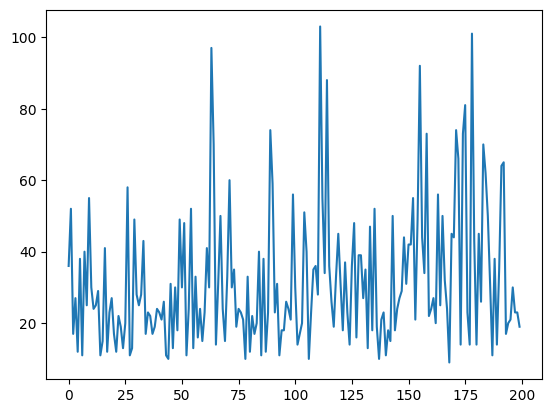

In [296]:
agent = REINFORCEAgent(env=cartpole_env, tiling=cartpole_tiling, alpha=0.00005, gamma=0.99, temp=1.0)
episode_rewards = agent.train(n_episodes=n_episodes)
ax = episode_rewards.episode_reward.plot()

In [297]:
class ActorCriticAgent:
    def __init__(self, env, tiling, alpha_actor, alpha_critic, gamma, temp, temp_decay_rate, run=0):
        self.name = "ActorCritic"
        self.run = run
        self.env = env
        self.env_name = env.unwrapped.spec.id
        self.tiling = tiling
        
        # Actor learning rate
        self.alpha_actor = alpha_actor
        
        # Critic learning rate
        self.alpha_critic = alpha_critic
        
        # Discount factor
        self.gamma = gamma
        self.temp = temp
        self.temp_decay_rate = temp_decay_rate
        
        # Action and observation space dimensions
        self.num_actions = env.action_space.n
        self.observation_dim = tiling.get_number_of_frames()

        # Actor parameter initialization (policy parameters)
        self.theta = np.random.uniform(-0.001, 0.001, (self.observation_dim, self.num_actions))
        
        # Critic parameter initialization (value function parameters)
        self.w = np.random.uniform(-0.001, 0.001, self.observation_dim)
    
    def __repr__(self):
        return f"{self.name}(run={self.run}, env={self.env_name}, alpha_actor={self.alpha_actor}, alpha_critic={self.alpha_critic}, gamma={self.gamma}, temp={self.temp}, temp_decay_rate={self.temp_decay_rate})"
    
    def policy(self, state):
        """Compute the policy using softmax"""
        preferences = np.dot(state, self.theta) / self.temp
        max_preference = np.max(preferences)
        exp_preferences = np.exp(preferences - max_preference)
        return exp_preferences / np.sum(exp_preferences)

    def select_action(self, state):
        """Select action according to the policy"""
        probabilities = self.policy(state)
        return np.random.choice(self.num_actions, p=probabilities)

    def value_function(self, state):
        """Compute the value of a state"""
        return np.dot(state, self.w)

    def update_temperature(self):
        """Update the temperature using exponential decay"""
        self.temp = self.temp * self.temp_decay_rate

    def update(self, state, action, reward, next_state, done):
        """
        Update the policy and value function based on the observed transition.

        :param state: The current state.
        :param action: The action taken.
        :param reward: The reward received.
        :param next_state: The next state.
        :param done: Flag indicating if the episode has ended.
        """
        # Compute the current estimate and the target
        value_curr = self.value_function(state)
        value_next = 0 if done else self.value_function(next_state)
        td_error = reward + self.gamma * value_next - value_curr

        # Update the critic (value function parameters)
        self.w += self.alpha_critic * td_error * state

        # Update the actor (policy parameters)
        softmax_probs = self.policy(state)
        grad_log_policy = np.outer(state, softmax_probs)
        grad_log_policy[:, action] -= state
        self.theta -= self.alpha_actor * td_error * grad_log_policy

    def train(self, n_episodes):
        initial_temp = self.temp

        train_history = []
        for episode in tqdm(range(n_episodes)):
            state, info = self.env.reset()
            state = self.tiling.get_active_tiles(state)
            done = False
        
            episode_reward = 0
            for step in range(self.env._max_episode_steps):
                action = self.select_action(state)
                next_state, reward, done, trunc, info = self.env.step(action)
                next_state = self.tiling.get_active_tiles(next_state)
                self.update(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                if done:
                    break
            
            if not self.temp_decay_rate == 1.0:
                self.update_temperature()  # Update the temperature after each episode
            
            train_history.append({
                'env': self.env_name,
                'run': self.run,
                'model_name': self.name,
                'episode': episode,
                'num_segments': step,
                'episode_reward': episode_reward,
                'alpha_actor': self.alpha_actor,
                'alpha_critic': self.alpha_critic,
                'gamma': self.gamma,
                'initial_temp': initial_temp,
                'temp': self.temp,
                'temp_decay_rate': self.temp_decay_rate
            })

        return pd.DataFrame(train_history)

  0%|          | 0/200 [00:00<?, ?it/s]

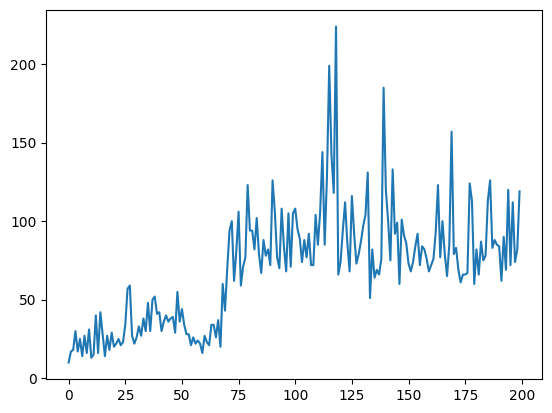

In [298]:
agent = ActorCriticAgent(cartpole_env, cartpole_tiling, alpha_actor=0.01, alpha_critic=0.01, gamma=0.99, temp=1.0, temp_decay_rate=0.99)
train_history = agent.train(n_episodes=n_episodes)
ax = train_history.episode_reward.plot()

## Parameter sweep

In [291]:
grid_size = 10000
temps = np.logspace(np.log10(0.01), np.log10(0.03), num=grid_size)
temp_rates = 1 - np.logspace(np.log10(0.001), np.log10(0.01), num=grid_size)
alphas = np.logspace(np.log10(0.01), np.log10(0.3), num=grid_size)
actor_alphas = np.logspace(np.log10(0.01), np.log10(0.05), num=grid_size)
critic_alphas = np.logspace(np.log10(0.01), np.log10(0.2), num=grid_size)
gammas = 1 - np.logspace(np.log10(0.02), np.log10(0.001), num=grid_size)

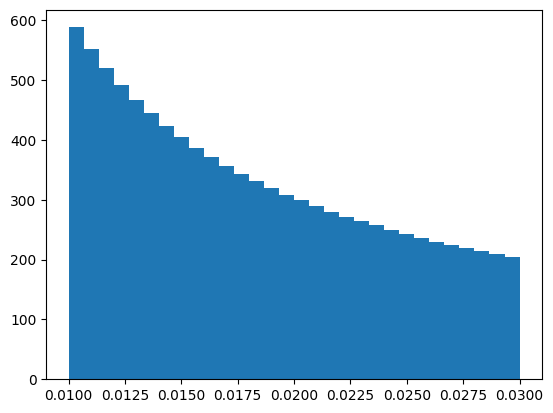

In [237]:
ax = plt.hist(temps, bins=30)

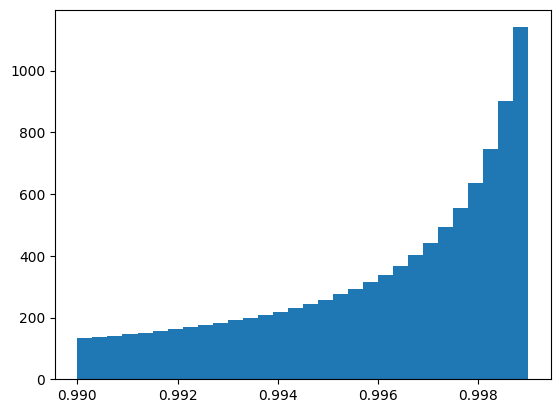

In [238]:
ax = plt.hist(temp_rates, bins=30)

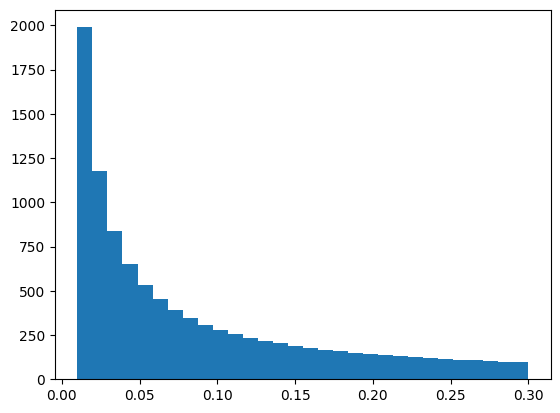

In [239]:
ax = plt.hist(alphas, bins=30)

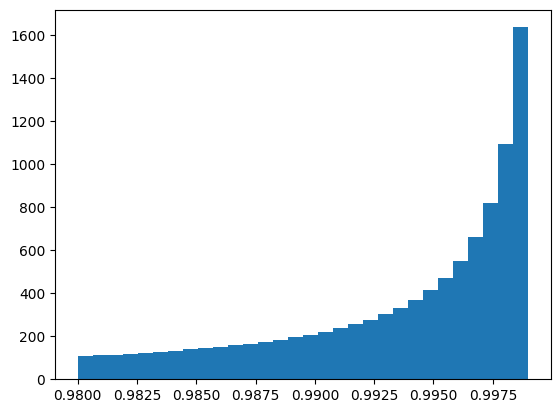

In [240]:
ax = plt.hist(gammas, bins=30)

In [ ]:
# Constants
envs = [(mountaincart_env, mountaincart_tiling), (cartpole_env, cartpole_tiling)]
agents = ['REINFORCE', 'ActorCritic']

def sample_distributions(temps, temp_rates, alphas, actor_alphas, critic_alphas, gammas, k):

    # Ensure k is not greater than grid_size
    k = min(k, grid_size)

    # Sampling k values from each distribution
    sampled_temps = np.random.choice(temps, k, replace=False)
    sampled_temp_rates = np.random.choice(temp_rates, k, replace=False)
    sampled_alphas = np.random.choice(alphas, k, replace=False)
    sampled_actor_alphas = np.random.choice(actor_alphas, k, replace=False)
    sampled_critic_alphas = np.random.choice(critic_alphas, k, replace=False)
    sampled_gammas = np.random.choice(gammas, k, replace=False)

    return sampled_temps, sampled_temp_rates, sampled_alphas, sampled_actor_alphas, \
        sampled_critic_alphas, sampled_gammas

sampled_temps, sampled_temp_rates, sampled_alphas, sampled_actor_alphas, \
        sampled_critic_alphas, sampled_gammas = sample_distributions(temps, temp_rates, alphas, actor_alphas, 
                                                                     critic_alphas, gammas, k=50)

def sweep_params(agent_names, envs, temps, temp_rates, alphas, actor_alphas, critic_alphas, gammas):
    for agent_name in agent_names:
        for env_tiling in envs:
            env, tiling = env_tiling
            for temp, temp_rate, alpha, actor_alpha, critic_alpha, gamma in \
                zip(temps, temp_rates, alphas, actor_alphas, critic_alphas, gammas):
                    if agent_name == 'REINFORCE':
                        yield REINFORCEAgent(
                            env=env, tiling=tiling, alpha=alpha, gamma=gamma, temp=temp, temp_decay_rate=temp_rate
                        )
                    else:
                        yield ActorCriticAgent(
                            env=env, tiling=tiling, alpha_actor=actor_alpha, alpha_critic=critic_alpha, gamma=gamma, temp=temp,
                            temp_decay_rate=temp_rate
                        )

trial_agents = [params for params in tqdm(sweep_params(agents, envs, sampled_temps, sampled_temp_rates, sampled_alphas, sampled_actor_alphas, \
        sampled_critic_alphas, sampled_gammas))]

In [243]:
results = train_parallel_agents(trial_agents, n_episodes=300)

  0%|          | 0/200 [00:00<?, ?it/s]

In [244]:
results_df = pd.concat([r[1] for r in results])
results_df

,env,run,model_name,episode,num_segments,episode_reward,alpha,gamma,temp,temp_decay_rate,alpha_actor,alpha_critic
0,MountainCar-v0,0,REINFORCE,0,199,-200.0,0.018693,0.986657,0.011201,0.998722,NaN,NaN
1,MountainCar-v0,0,REINFORCE,1,199,-200.0,0.018693,0.986657,0.011186,0.998722,NaN,NaN
2,MountainCar-v0,0,REINFORCE,2,199,-200.0,0.018693,0.986657,0.011172,0.998722,NaN,NaN
3,MountainCar-v0,0,REINFORCE,3,199,-200.0,0.018693,0.986657,0.011158,0.998722,NaN,NaN
4,MountainCar-v0,0,REINFORCE,4,199,-200.0,0.018693,0.986657,0.011144,0.998722,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
295,CartPole-v1,0,ActorCritic,295,7,8.0,NaN,0.995770,0.004266,0.994156,0.040189,0.080224
296,CartPole-v1,0,ActorCritic,296,8,9.0,NaN,0.995770,0.004241,0.994156,0.040189,0.080224
297,CartPole-v1,0,ActorCritic,297,8,9.0,NaN,0.995770,0.004217,0.994156,0.040189,0.080224
298,CartPole-v1,0,ActorCritic,298,9,10.0,NaN,0.995770,0.004192,0.994156,0.040189,0.080224


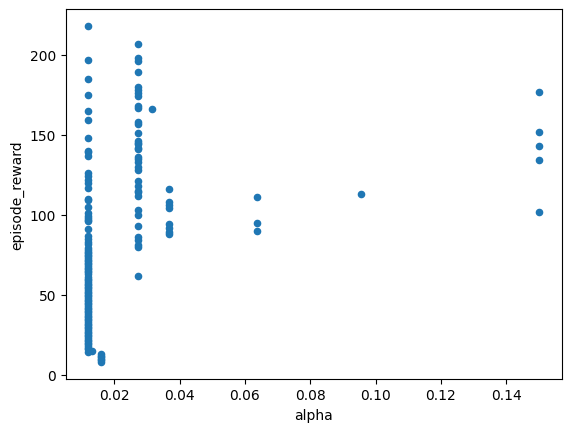

In [245]:
ax = reinforce_return[reinforce_return.env == 'CartPole-v1'].plot(kind='scatter', x='alpha', y='episode_reward')

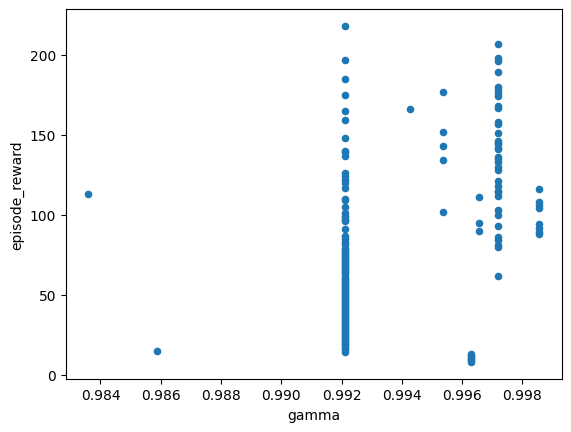

In [246]:
ax = reinforce_return[reinforce_return.env == 'CartPole-v1'].plot(kind='scatter', x='gamma', y='episode_reward')

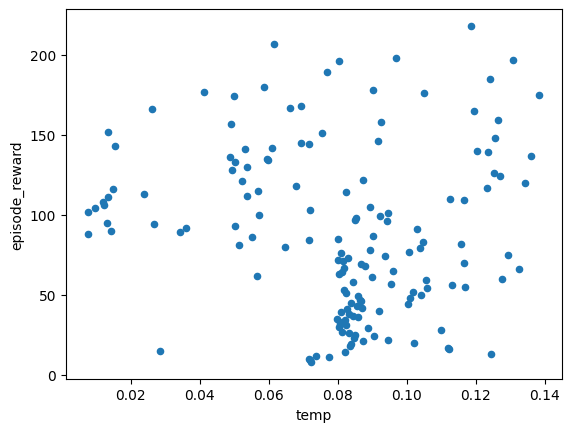

In [247]:
ax = reinforce_return[reinforce_return.env == 'CartPole-v1'].plot(kind='scatter', x='temp', y='episode_reward')

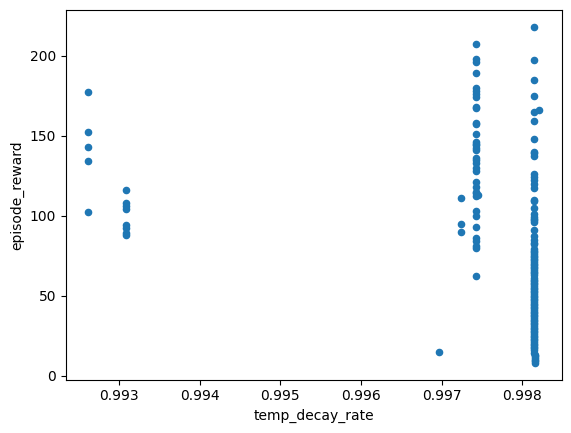

In [248]:
ax = reinforce_return[reinforce_return.env == 'CartPole-v1'].plot(kind='scatter', x='temp_decay_rate', y='episode_reward')

In [249]:
reinforce_return = (results_df
     .groupby(['env', 'model_name', 'alpha', 'gamma', 'temp', 'temp_decay_rate'])
     .episode_reward
     .sum()
     .to_frame()
     .drop_duplicates()
     .reset_index()
     .sort_values('episode_reward', ascending=False)
)
reinforce_return

,env,model_name,alpha,gamma,temp,temp_decay_rate,episode_reward
241,CartPole-v1,REINFORCE,0.184824,0.994889,0.007678,0.998177,500.0
278,CartPole-v1,REINFORCE,0.184824,0.994889,0.008582,0.998177,486.0
239,CartPole-v1,REINFORCE,0.184824,0.994889,0.007650,0.998177,484.0
262,CartPole-v1,REINFORCE,0.184824,0.994889,0.008185,0.998177,483.0
345,CartPole-v1,REINFORCE,0.184824,0.994889,0.011326,0.998177,481.0
...,...,...,...,...,...,...,...
373,MountainCar-v0,REINFORCE,0.025657,0.995659,0.004083,0.993055,-179.0
372,MountainCar-v0,REINFORCE,0.025657,0.995659,0.003652,0.993055,-180.0
375,MountainCar-v0,REINFORCE,0.025657,0.995659,0.007698,0.993055,-181.0
397,MountainCar-v0,REINFORCE,0.055816,0.985089,0.016895,0.998995,-194.0


In [250]:
actorcritic_return = (results_df
     .groupby(['env', 'model_name', 'alpha_actor', 'alpha_critic', 'gamma', 'temp', 'temp_decay_rate'])
     .episode_reward
     .sum()
     .to_frame()
     .drop_duplicates()
     .reset_index()
     .sort_values('episode_reward', ascending=False)
)
actorcritic_return

,env,model_name,alpha_actor,alpha_critic,gamma,temp,temp_decay_rate,episode_reward
195,CartPole-v1,ActorCritic,0.021301,0.047376,0.989626,0.012985,0.995271,500.0
221,CartPole-v1,ActorCritic,0.029897,0.107119,0.989703,0.013770,0.998889,469.0
226,CartPole-v1,ActorCritic,0.029897,0.107119,0.989703,0.013862,0.998889,458.0
216,CartPole-v1,ActorCritic,0.029897,0.107119,0.989703,0.013632,0.998889,448.0
192,CartPole-v1,ActorCritic,0.021301,0.047376,0.989626,0.012802,0.995271,439.0
...,...,...,...,...,...,...,...,...
339,MountainCar-v0,ActorCritic,0.011663,0.122104,0.990855,0.016511,0.998533,-196.0
348,MountainCar-v0,ActorCritic,0.022938,0.013501,0.997263,0.020359,0.998032,-197.0
267,MountainCar-v0,ActorCritic,0.010164,0.032035,0.993829,0.020240,0.998908,-198.0
263,MountainCar-v0,ActorCritic,0.010164,0.032035,0.993829,0.019976,0.998908,-199.0


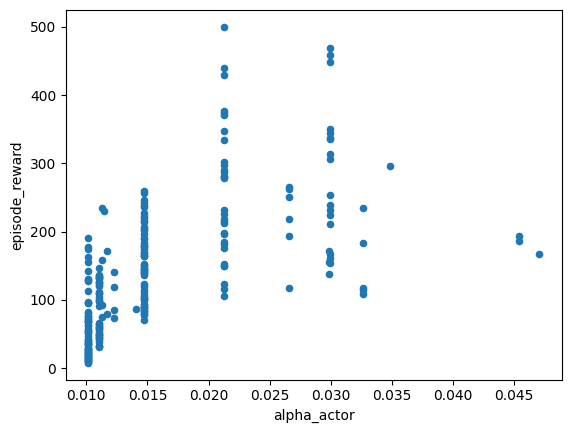

In [251]:
ax = actorcritic_return[actorcritic_return.env == 'CartPole-v1'].plot(kind='scatter', x='alpha_actor', y='episode_reward')

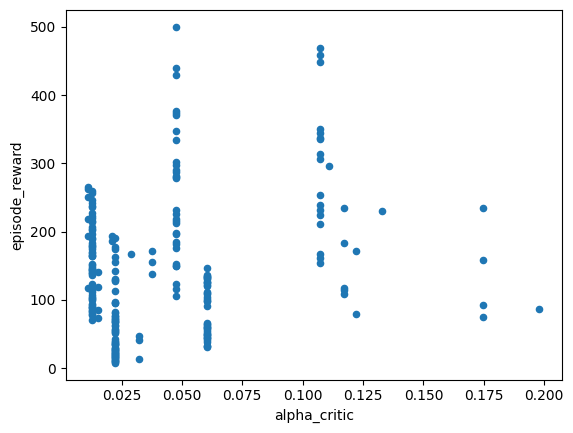

In [252]:
ax = actorcritic_return[actorcritic_return.env == 'CartPole-v1'].plot(kind='scatter', x='alpha_critic', y='episode_reward')

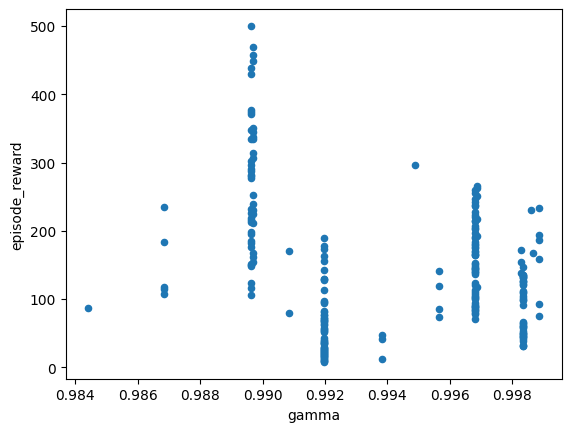

In [253]:
ax = actorcritic_return[actorcritic_return.env == 'CartPole-v1'].plot(kind='scatter', x='gamma', y='episode_reward')

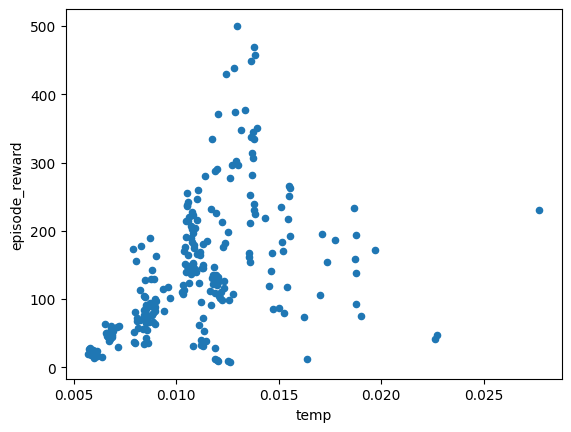

In [254]:
ax = actorcritic_return[actorcritic_return.env == 'CartPole-v1'].plot(kind='scatter', x='temp', y='episode_reward')

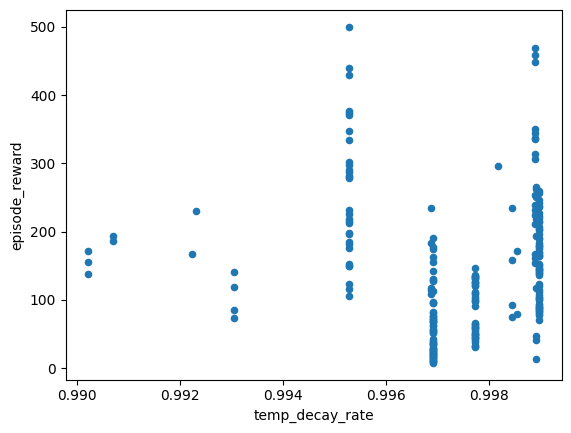

In [255]:
ax = actorcritic_return[actorcritic_return.env == 'CartPole-v1'].plot(kind='scatter', x='temp_decay_rate', y='episode_reward')

## Trials
- Run 50 learning trials with different initializations for $Q$, each having 1000 episodes for the following two configurations: 1. A fixed temperature $T > 0$ (of your choice) and 2. A decreasing temperature $T$. (50 runs \* 1000 episodes \* 2 configs) You are free to choose your own step sizes for these implementations.
- Plot the average performance of the policy on the $Y$-axis and the number of episodes on the $X$-axis. The plots should also include the interquantile range of the 50 independent runs. Note that you are expected to plot 4 results for 2 configurations per environment and document your findings in a separate PDF along with the results. Explain why one algorithm performs better than the other or why a particular configuration results in better performance.
- Similar to value-based methods, you have to implement all the code without using any automatic differentiation package, and you are required to cite any material sourced from the internet.

In [339]:
def generate_trial_agents(agent_names, envs, runs):
    alpha = 0.01
    alpha_actor = 0.02
    alpha_critic = 0.01
    gamma = 0.99
    temps = [0.1, 1.0]
    temp_rates = [1.0, 0.99]
    
    for agent_name, env, tiling, temp, temp_rate, run in zip(agent_names, *envs, temps, temp_rates, range(runs)):
        if agent_name == 'REINFORCE':
            yield REINFORCEAgent(
                env=env, tiling=tiling, alpha=alpha, gamma=gamma, temp=temp, temp_decay_rate=temp_rate, run=run
            )
        else:
            yield ActorCriticAgent(
                env=env, tiling=tiling, alpha_actor=alpha_actor, alpha_critic=alpha_critic, gamma=gamma, temp=temp,
                temp_decay_rate=temp_rate, run=run
            )

trial_agents = list(generate_trial_agents(agents, envs, runs=50))

In [340]:
results = train_parallel_agents(trial_agents, n_episodes=1000)

  0%|          | 0/400 [00:00<?, ?it/s]

Process ForkPoolWorker-247:
Process ForkPoolWorker-244:
Process ForkPoolWorker-243:
Process ForkPoolWorker-256:
Process ForkPoolWorker-246:
Process ForkPoolWorker-257:
Process ForkPoolWorker-255:
Process ForkPoolWorker-251:
Process ForkPoolWorker-254:
Process ForkPoolWorker-245:
Process ForkPoolWorker-258:
Process ForkPoolWorker-253:
Process ForkPoolWorker-248:
Process ForkPoolWorker-249:

KeyboardInterrupt

Process ForkPoolWorker-252:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most rece

In [ ]:
results_df = pd.concat([r[1] for r in results])

plot_df = (results_df
     .groupby(['env', 'model_name', 'episode', 'initial_temp', 'temp_decay_rate'])
     ['episode_reward']
     .agg(['mean', lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.75)])
     .reset_index()
     .rename(columns={"<lambda_0>": "q25", "<lambda_1>": "q75"})
)
plot_df['Parameters'] = plot_df.apply(lambda x: f'temp={x.initial_temp}, temp_decay_rate={x.temp_decay_rate}', axis=1)
plot_df.head()

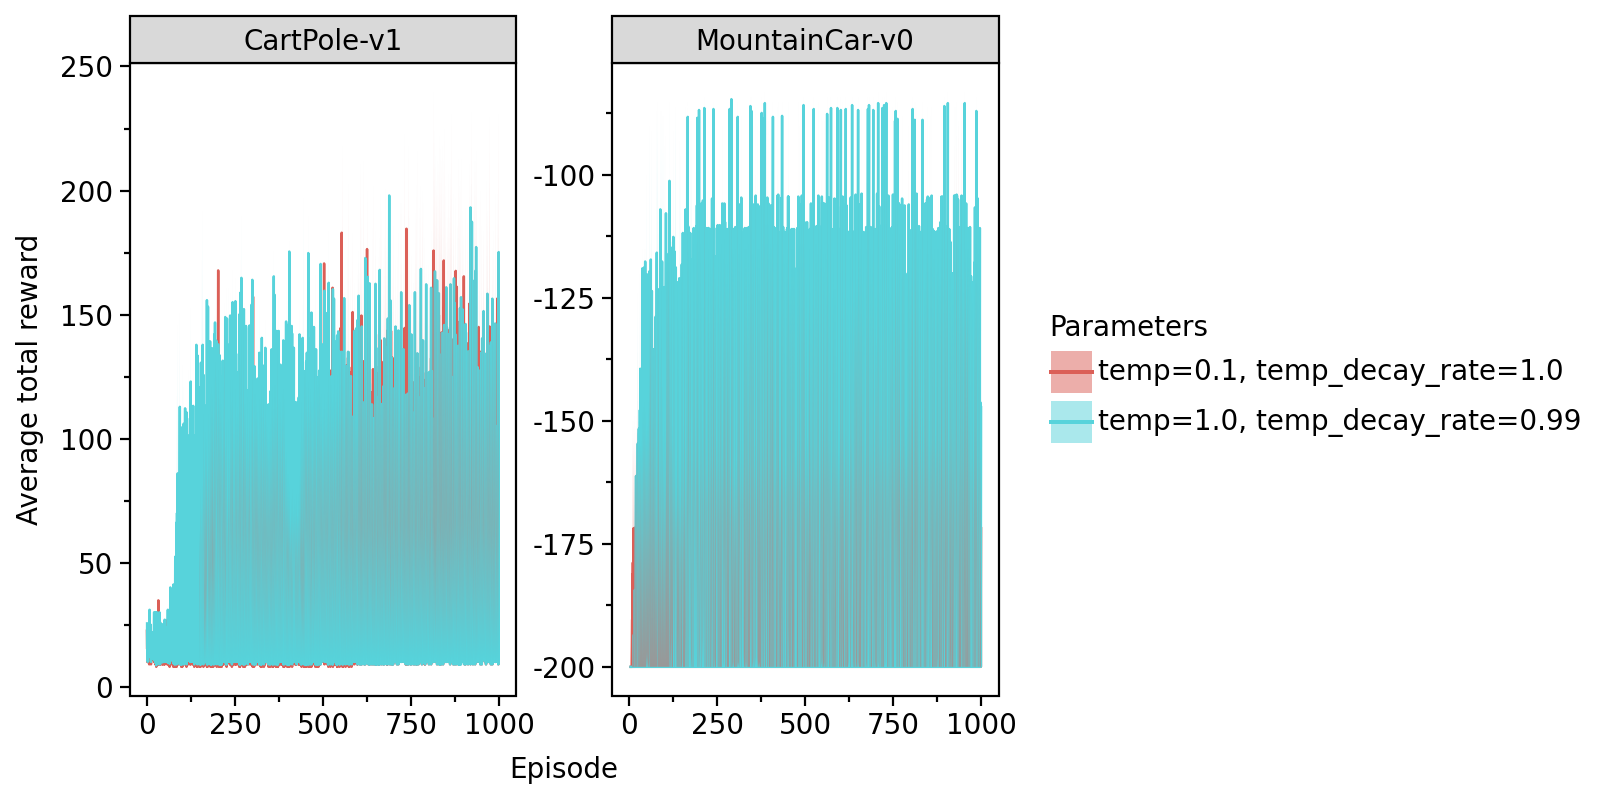

In [338]:
(ggplot(plot_df) +
     geom_line(aes(x="episode", y="mean", color="Parameters")) +
     facet_wrap('env', scales='free_y') +
     geom_ribbon(aes(x="episode", ymin = 'q25', ymax = 'q75', fill="Parameters"), alpha = 0.5) +
     ylab('Average total reward') +
     xlab('Episode') +
     theme_matplotlib()
)